# 02 — Modeling & Fraud Detection


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.metrics import (  # noqa: F401
        precision_score, recall_score, f1_score, roc_auc_score, 
        average_precision_score, roc_curve, confusion_matrix, 
        classification_report, precision_recall_curve
    )
    from imblearn.over_sampling import SMOTE
    print("✓ All imports successful!")
except ImportError as e:
    print(f"✗ Import Error: {e}")
    print("\n⚠️  scikit-learn installation appears to be corrupted.")
    print("   Please reinstall scikit-learn:")
    print("   pip install --force-reinstall scikit-learn")
    print("\n   Note: You may need to free up disk space on C: drive first.")
    raise

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 200)
sns.set_theme(style="whitegrid")


✓ All imports successful!


## 1. Load Provider-Level Data


In [ ]:
# Load provider-level features
df = pd.read_csv("../data/provider_level_features.csv")

# Print shape and head
print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Print column names
print("\nColumn names:")
print(df.columns.tolist())

# Separate target column
if "PotentialFraud" in df.columns:
    # Convert Yes/No to 1/0
    df["fraud_flag"] = df["PotentialFraud"].map({"Yes": 1, "No": 0, "Y": 1, "N": 0})
    print("\nFraud flag distribution:")
    print(df["fraud_flag"].value_counts())
else:
    print("\nWarning: 'PotentialFraud' column not found in dataset")

# Set features and target
X = df.drop(["PotentialFraud", "fraud_flag"], axis=1)
y = df["fraud_flag"]

print(f"\nFeatures shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")


Data shape: (5410, 13)

First few rows:
   Provider PotentialFraud  num_inpatient_claims  num_outpatient_claims  \
0  PRV51001             No                     5                     20   
1  PRV51003            Yes                    62                     70   
2  PRV51004             No                     0                    149   
3  PRV51005            Yes                     0                   1165   
4  PRV51007             No                     3                     69   

   total_claims  ip_reimb_mean  ip_reimb_sum  ip_deduct_mean  ip_deduct_sum  \
0            25   19400.000000       97000.0          1068.0         5340.0   
1           132    9241.935484      573000.0          1068.0        66216.0   
2           149            NaN           NaN             NaN            NaN   
3          1165            NaN           NaN             NaN            NaN   
4            72    6333.333333       19000.0          1068.0         3204.0   

   op_reimb_mean  op_reimb_sum  op

## 2. Train/Test Split


In [3]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# Print shapes of each set
print("Training set shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print("\nTest set shapes:")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

print("\nTarget distribution in training set:")
print(y_train.value_counts())

print("\nTarget distribution in test set:")
print(y_test.value_counts())


Training set shapes:
X_train: (4328, 12)
y_train: (4328,)

Test set shapes:
X_test: (1082, 12)
y_test: (1082,)

Target distribution in training set:
fraud_flag
0    3923
1     405
Name: count, dtype: int64

Target distribution in test set:
fraud_flag
0    981
1    101
Name: count, dtype: int64


## 3. Imbalance Handling Strategy


In [7]:
# Import SMOTE (already imported in setup, but shown here for clarity)
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Select only numeric columns (SMOTE cannot handle non-numeric columns)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

if non_numeric_cols:
    print(f"Warning: Dropping non-numeric columns before SMOTE: {non_numeric_cols}")
    X_train = X_train[numeric_cols]
    X_test = X_test[numeric_cols]

print(f"\nUsing {len(numeric_cols)} numeric features for modeling")

# Check for missing values before SMOTE (SMOTE cannot handle NaN)
print("\nMissing values in X_train:")
print(X_train.isna().sum())
print(f"\nTotal missing values: {X_train.isna().sum().sum()}")

# Impute missing values with median (fit on train, transform both train and test)
if X_train.isna().sum().sum() > 0:
    print("\nImputing missing values with median...")
    imputer = SimpleImputer(strategy="median")
    X_train = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    # Fill any remaining NaN (in case all values in a column were NaN)
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    print("Missing values imputed successfully!")
else:
    print("\nNo missing values found. Proceeding with SMOTE...")

# Verify no missing values remain
print(f"\nFinal check - Missing values in X_train: {X_train.isna().sum().sum()}")
print(f"Final check - Missing values in X_test: {X_test.isna().sum().sum()}")

# Print class counts before oversampling
print("\nClass distribution BEFORE oversampling:")
print(y_train.value_counts())
print(f"\nClass ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1 (No:Yes)")

# Apply SMOTE to balance the training data
print("\nApplying SMOTE...")
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Print class counts after oversampling
print("\n" + "="*50)
print("Class distribution AFTER oversampling:")
print(y_train_sm.value_counts())
print(f"\nClass ratio: {y_train_sm.value_counts()[0] / y_train_sm.value_counts()[1]:.2f}:1 (No:Yes)")

print(f"\nTraining set shape before SMOTE: {X_train.shape}")
print(f"Training set shape after SMOTE: {X_train_sm.shape}")



Using 11 numeric features for modeling

Missing values in X_train:
num_inpatient_claims     0
num_outpatient_claims    0
total_claims             0
ip_reimb_mean            0
ip_reimb_sum             0
ip_deduct_mean           0
ip_deduct_sum            0
op_reimb_mean            0
op_reimb_sum             0
op_deduct_mean           0
op_deduct_sum            0
dtype: int64

Total missing values: 0

No missing values found. Proceeding with SMOTE...

Final check - Missing values in X_train: 0
Final check - Missing values in X_test: 0

Class distribution BEFORE oversampling:
fraud_flag
0    3923
1     405
Name: count, dtype: int64

Class ratio: 9.69:1 (No:Yes)

Applying SMOTE...

Class distribution AFTER oversampling:
fraud_flag
0    3923
1    3923
Name: count, dtype: int64

Class ratio: 1.00:1 (No:Yes)

Training set shape before SMOTE: (4328, 11)
Training set shape after SMOTE: (7846, 11)


## 4. Baseline Models


In [8]:
# Train baseline models on SMOTE-resampled data
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# Initialize models
lr_baseline = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)
dt_baseline = DecisionTreeClassifier(class_weight="balanced", random_state=42)

# Train models
print("Training baseline models...")
lr_baseline.fit(X_train_sm, y_train_sm)
dt_baseline.fit(X_train_sm, y_train_sm)
print("Training complete!\n")

# Make predictions on test set
y_pred_lr = lr_baseline.predict(X_test)
y_pred_dt = dt_baseline.predict(X_test)

# Get probability predictions for ROC-AUC and PR-AUC
y_pred_proba_lr = lr_baseline.predict_proba(X_test)[:, 1]
y_pred_proba_dt = dt_baseline.predict_proba(X_test)[:, 1]

# Compute metrics for Logistic Regression
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
pr_auc_lr = average_precision_score(y_test, y_pred_proba_lr)

# Compute metrics for Decision Tree
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
pr_auc_dt = average_precision_score(y_test, y_pred_proba_dt)

# Print results
print("="*60)
print("BASELINE MODEL PERFORMANCE METRICS")
print("="*60)

print("\n1. Logistic Regression (class_weight='balanced'):")
print(f"   Precision:  {precision_lr:.4f}")
print(f"   Recall:     {recall_lr:.4f}")
print(f"   F1-Score:   {f1_lr:.4f}")
print(f"   ROC-AUC:    {roc_auc_lr:.4f}")
print(f"   PR-AUC:     {pr_auc_lr:.4f}")

print("\n2. Decision Tree (class_weight='balanced'):")
print(f"   Precision:  {precision_dt:.4f}")
print(f"   Recall:     {recall_dt:.4f}")
print(f"   F1-Score:   {f1_dt:.4f}")
print(f"   ROC-AUC:    {roc_auc_dt:.4f}")
print(f"   PR-AUC:     {pr_auc_dt:.4f}")

print("\n" + "="*60)


Training baseline models...
Training complete!

BASELINE MODEL PERFORMANCE METRICS

1. Logistic Regression (class_weight='balanced'):
   Precision:  0.3982
   Recall:     0.8911
   F1-Score:   0.5505
   ROC-AUC:    0.9488
   PR-AUC:     0.7323

2. Decision Tree (class_weight='balanced'):
   Precision:  0.4294
   Recall:     0.6931
   F1-Score:   0.5303
   ROC-AUC:    0.7988
   PR-AUC:     0.3263



## 5. Primary Model


Training Gradient Boosting Classifier...
Training complete!

GRADIENT BOOSTING CLASSIFIER - CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Fraud       0.98      0.91      0.94       981
       Fraud       0.47      0.80      0.59       101

    accuracy                           0.90      1082
   macro avg       0.72      0.85      0.76      1082
weighted avg       0.93      0.90      0.91      1082


CONFUSION MATRIX
[[888  93]
 [ 20  81]]

True Negatives: 888, False Positives: 93
False Negatives: 20, True Positives: 81

PERFORMANCE METRICS
Precision:  0.4655
Recall:     0.8020
F1-Score:   0.5891
ROC-AUC:    0.9443
PR-AUC:     0.7382


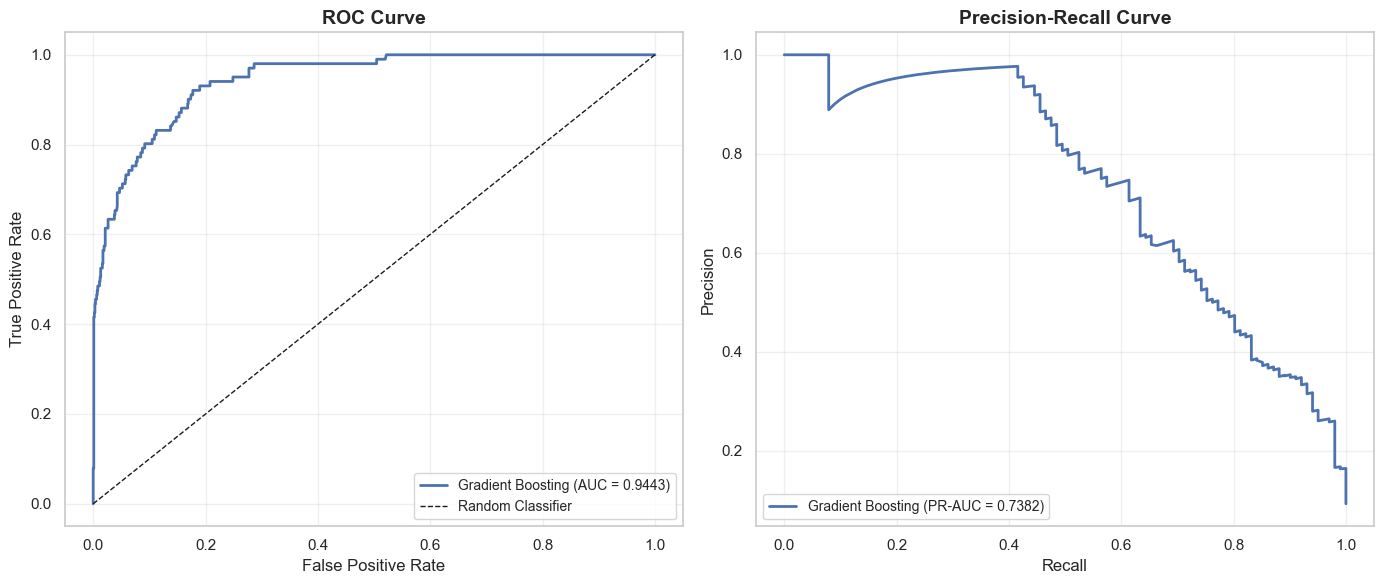

In [9]:
# Define and train Gradient Boosting Classifier
gb_primary = GradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=3,
    n_estimators=300,
    random_state=42
)

# Train on SMOTE-resampled training data
print("Training Gradient Boosting Classifier...")
gb_primary.fit(X_train_sm, y_train_sm)
print("Training complete!\n")

# Predict on test set
y_pred_gb = gb_primary.predict(X_test)
y_pred_proba_gb = gb_primary.predict_proba(X_test)[:, 1]

# Compute metrics
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
pr_auc_gb = average_precision_score(y_test, y_pred_proba_gb)

# Print classification report
print("="*60)
print("GRADIENT BOOSTING CLASSIFIER - CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_gb, target_names=['No Fraud', 'Fraud']))

# Print confusion matrix
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)
cm = confusion_matrix(y_test, y_pred_gb)
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

# Print all metrics
print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)
print(f"Precision:  {precision_gb:.4f}")
print(f"Recall:     {recall_gb:.4f}")
print(f"F1-Score:   {f1_gb:.4f}")
print(f"ROC-AUC:    {roc_auc_gb:.4f}")
print(f"PR-AUC:     {pr_auc_gb:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_gb)

plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {roc_auc_gb:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba_gb)
plt.plot(recall_curve, precision_curve, label=f'Gradient Boosting (PR-AUC = {pr_auc_gb:.4f})', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Hyperparameter Tuning


In [10]:
# Define parameter grid for GridSearchCV
param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [2, 3, 4],
    "learning_rate": [0.01, 0.05, 0.1],
}

# Initialize base model
gb_base = GradientBoostingClassifier(random_state=42)

# Set up GridSearchCV with 5-fold CV
print("Starting GridSearchCV with 5-fold cross-validation...")
print("This may take several minutes...\n")

grid_search = GridSearchCV(
    estimator=gb_base,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on SMOTE-resampled data
grid_search.fit(X_train_sm, y_train_sm)

# Print results
print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest F1 Score (CV): {grid_search.best_score_:.4f}")

# Store best estimator
best_model = grid_search.best_estimator_

print("\nBest model stored as 'best_model'")
print("="*60)


Starting GridSearchCV with 5-fold cross-validation...
This may take several minutes...

Fitting 5 folds for each of 27 candidates, totalling 135 fits

GRID SEARCH RESULTS

Best Parameters:
  learning_rate: 0.1
  max_depth: 4
  n_estimators: 600

Best F1 Score (CV): 0.9377

Best model stored as 'best_model'


## 7. Model Comparison


MODEL COMPARISON - PERFORMANCE METRICS
                    Model  precision   recall       f1  roc_auc   pr_auc
      Logistic Regression   0.398230 0.891089 0.550459 0.948850 0.732252
            Decision Tree   0.429448 0.693069 0.530303 0.798821 0.326288
Gradient Boosting (Tuned)   0.543478 0.742574 0.627615 0.930481 0.715463


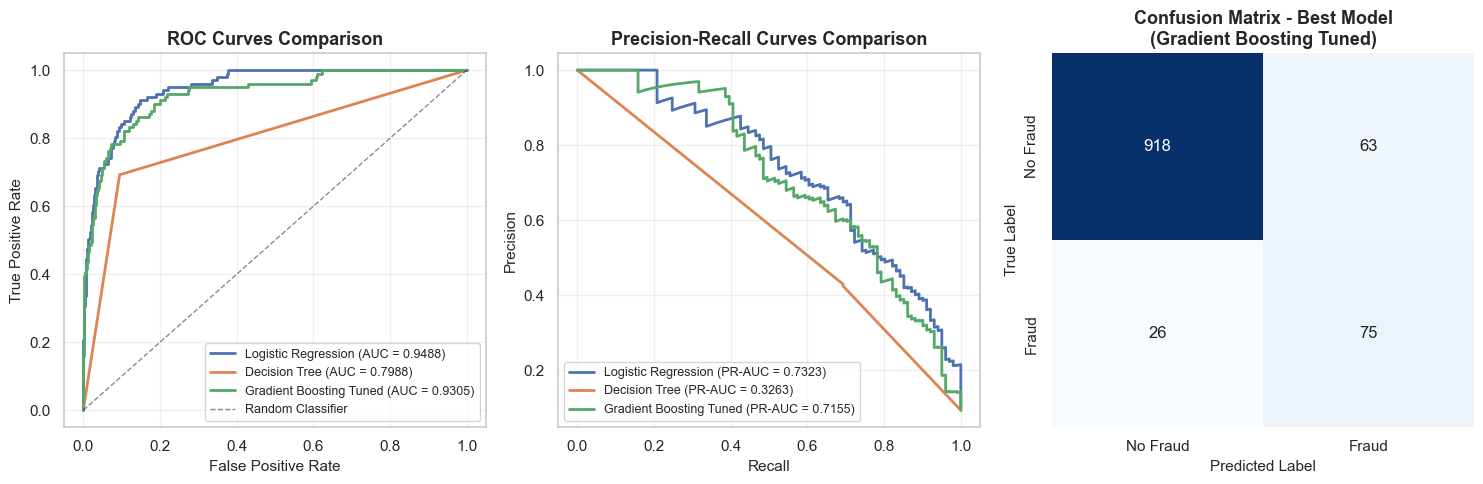

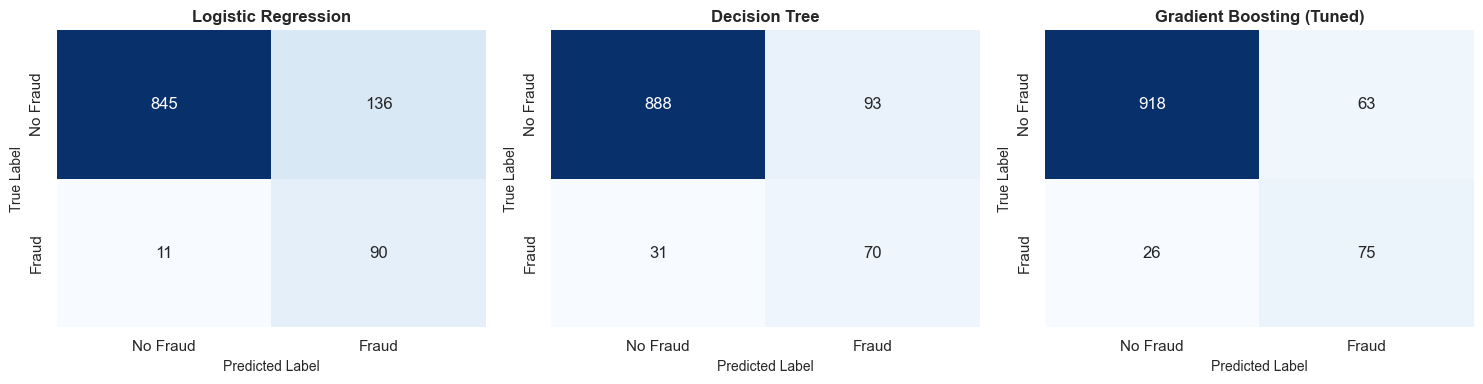

In [11]:
# Get predictions from best_model (tuned model)
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

# Compute metrics for best_model
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)
pr_auc_best = average_precision_score(y_test, y_pred_proba_best)

# Create comparison dataframe
comparison_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Gradient Boosting (Tuned)'],
    'precision': [precision_lr, precision_dt, precision_best],
    'recall': [recall_lr, recall_dt, recall_best],
    'f1': [f1_lr, f1_dt, f1_best],
    'roc_auc': [roc_auc_lr, roc_auc_dt, roc_auc_best],
    'pr_auc': [pr_auc_lr, pr_auc_dt, pr_auc_best]
}

comparison_df = pd.DataFrame(comparison_data)

# Display comparison table
print("="*70)
print("MODEL COMPARISON - PERFORMANCE METRICS")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Get ROC curve data for all models
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)

# Get PR curve data for all models
precision_curve_lr, recall_curve_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
precision_curve_dt, recall_curve_dt, _ = precision_recall_curve(y_test, y_pred_proba_dt)
precision_curve_best, recall_curve_best, _ = precision_recall_curve(y_test, y_pred_proba_best)

# Plot ROC curves for all models
plt.figure(figsize=(15, 5))

# ROC Curves
plt.subplot(1, 3, 1)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})', linewidth=2)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.4f})', linewidth=2)
plt.plot(fpr_best, tpr_best, label=f'Gradient Boosting Tuned (AUC = {roc_auc_best:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1, alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curves Comparison', fontsize=13, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.grid(alpha=0.3)

# Precision-Recall Curves
plt.subplot(1, 3, 2)
plt.plot(recall_curve_lr, precision_curve_lr, label=f'Logistic Regression (PR-AUC = {pr_auc_lr:.4f})', linewidth=2)
plt.plot(recall_curve_dt, precision_curve_dt, label=f'Decision Tree (PR-AUC = {pr_auc_dt:.4f})', linewidth=2)
plt.plot(recall_curve_best, precision_curve_best, label=f'Gradient Boosting Tuned (PR-AUC = {pr_auc_best:.4f})', linewidth=2)
plt.xlabel('Recall', fontsize=11)
plt.ylabel('Precision', fontsize=11)
plt.title('Precision-Recall Curves Comparison', fontsize=13, fontweight='bold')
plt.legend(loc='lower left', fontsize=9)
plt.grid(alpha=0.3)

# Confusion Matrices
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_best = confusion_matrix(y_test, y_pred_best)

plt.subplot(1, 3, 3)
# Create a combined visualization or show the best model's confusion matrix
# For clarity, we'll show the best model's confusion matrix
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.title('Confusion Matrix - Best Model\n(Gradient Boosting Tuned)', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=11)
plt.xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

# Plot all confusion matrices separately
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Logistic Regression Confusion Matrix
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False,
            xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
axes[0].set_title('Logistic Regression', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=10)
axes[0].set_xlabel('Predicted Label', fontsize=10)

# Decision Tree Confusion Matrix
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False,
            xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
axes[1].set_title('Decision Tree', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=10)
axes[1].set_xlabel('Predicted Label', fontsize=10)

# Best Model Confusion Matrix
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', ax=axes[2], cbar=False,
            xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
axes[2].set_title('Gradient Boosting (Tuned)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('True Label', fontsize=10)
axes[2].set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.show()


## 8. Save Trained Models


In [12]:
import joblib
import os

# Get feature names
feature_names = list(X_train.columns)

# Prepare model artifacts
model_artifacts = {
    'model': best_model,
    'feature_names': feature_names
}

# Check if scaler was used (add if you have one)
# If you used a scaler, uncomment and add it:
# model_artifacts['scaler'] = scaler

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save model artifacts
model_path = '../models/primary_model.pkl'
joblib.dump(model_artifacts, model_path)

print("="*60)
print("MODEL SAVED SUCCESSFULLY")
print("="*60)
print(f"Saved to: {model_path}")
print(f"\nSaved artifacts:")
print(f"  - Model: {type(best_model).__name__}")
print(f"  - Feature names: {len(feature_names)} features")
if 'scaler' in model_artifacts:
    print(f"  - Scaler: {type(model_artifacts['scaler']).__name__}")
print("="*60)


MODEL SAVED SUCCESSFULLY
Saved to: ../models/primary_model.pkl

Saved artifacts:
  - Model: GradientBoostingClassifier
  - Feature names: 11 features


In [13]:
# Setup: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn model classes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)

# Imbalanced-learn methods
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier

# Set display options
pd.set_option("display.max_columns", 200)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
